# Çoklu Doğrusal Regresyon

### Bir ev satışı veri seti kullanarak, evlerin satış fiyatlarını tahmin etmeye çalışacağız. Bu veri seti, evlerin özelliklerini (odaların sayısı, banyoların sayısı, ev büyüklüğü, konum vb.) içerecektir.

### değişkenler: ev büyüklüğü, odaların sayısı, banyoların sayısı, konum, inşa yılı, kat sayısı, satış fiyatları

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

In [3]:
# veri setini oluşturalım.

np.random.seed(0)
size = 500 # gözlem sayısı
rooms = np.random.randint(1, 6, size) # oda sayısı
baths = np.random.randint(1, 4, size) # banyo sayısı
sqft = np.random.randint(500, 3501, size) # ev büyüklüğü
location = np.random.choice(['A', 'B', 'C', 'D', 'E'], size) # konum
year = np.random.randint(1950, 2022, size) # inşa yılı
floors = np.random.randint(1, 4, size) # kat sayısı
price = 5000 + 200 * sqft + 10000 + rooms + 15000 * baths + 5000 * floors + np.random.normal(0, 10000, size) # satış fiyatı

data = pd.DataFrame({
    'Size': sqft, 'Rooms':rooms, 'Baths':baths, 'Location':location, 'Year':year,
    'Floors':floors, 'Price':price
})

data.head()

,Size,Rooms,Baths,Location,Year,Floors,Price
0,3183,5,2,A,2008,3,707105.607678
1,603,1,3,C,1961,2,196458.459536
2,2227,4,3,A,1999,2,508298.073802
3,1199,4,1,C,1953,2,256996.466357
4,2677,4,3,B,1961,2,616396.304566


# Veri Analiz - Ön İşleme

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Size,500.0,2021.116000,867.964813,516.000000,1266.500000,2092.500000,2764.500000,3493.000000
Rooms,500.0,2.998000,1.413503,1.000000,2.000000,3.000000,4.000000,5.000000
Baths,500.0,2.034000,0.811271,1.000000,1.000000,2.000000,3.000000,3.000000
Year,500.0,1984.998000,20.698378,1950.000000,1966.000000,1985.000000,2002.250000,2021.000000
Floors,500.0,2.016000,0.820421,1.000000,1.000000,2.000000,3.000000,3.000000
Price,500.0,459550.929483,175746.698302,137181.897614,306906.802796,469150.766819,612702.785315,785103.930047


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Size      500 non-null    int32  
 1   Rooms     500 non-null    int32  
 2   Baths     500 non-null    int32  
 3   Location  500 non-null    object 
 4   Year      500 non-null    int32  
 5   Floors    500 non-null    int32  
 6   Price     500 non-null    float64
dtypes: float64(1), int32(5), object(1)
memory usage: 17.7+ KB


In [7]:
# eksik gözlem analizi
data.isnull().sum()

Size        0
Rooms       0
Baths       0
Location    0
Year        0
Floors      0
Price       0
dtype: int64

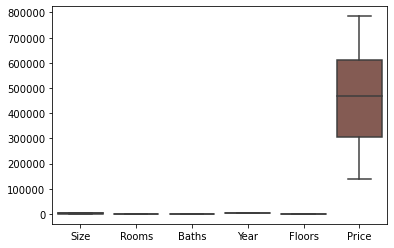

In [8]:
# aykırı gözlem analizi
sns.boxplot(data=data);

In [9]:
data.corr()

,Size,Rooms,Baths,Year,Floors,Price
Size,1.000000,-0.030694,0.010482,0.071496,0.032372,0.995590
Rooms,-0.030694,1.000000,0.075205,-0.030412,0.012124,-0.028713
Baths,0.010482,0.075205,1.000000,-0.048091,-0.067059,0.082384
Year,0.071496,-0.030412,-0.048091,1.000000,0.127455,0.076692
Floors,0.032372,0.012124,-0.067059,0.127455,1.000000,0.051960
Price,0.995590,-0.028713,0.082384,0.076692,0.051960,1.000000


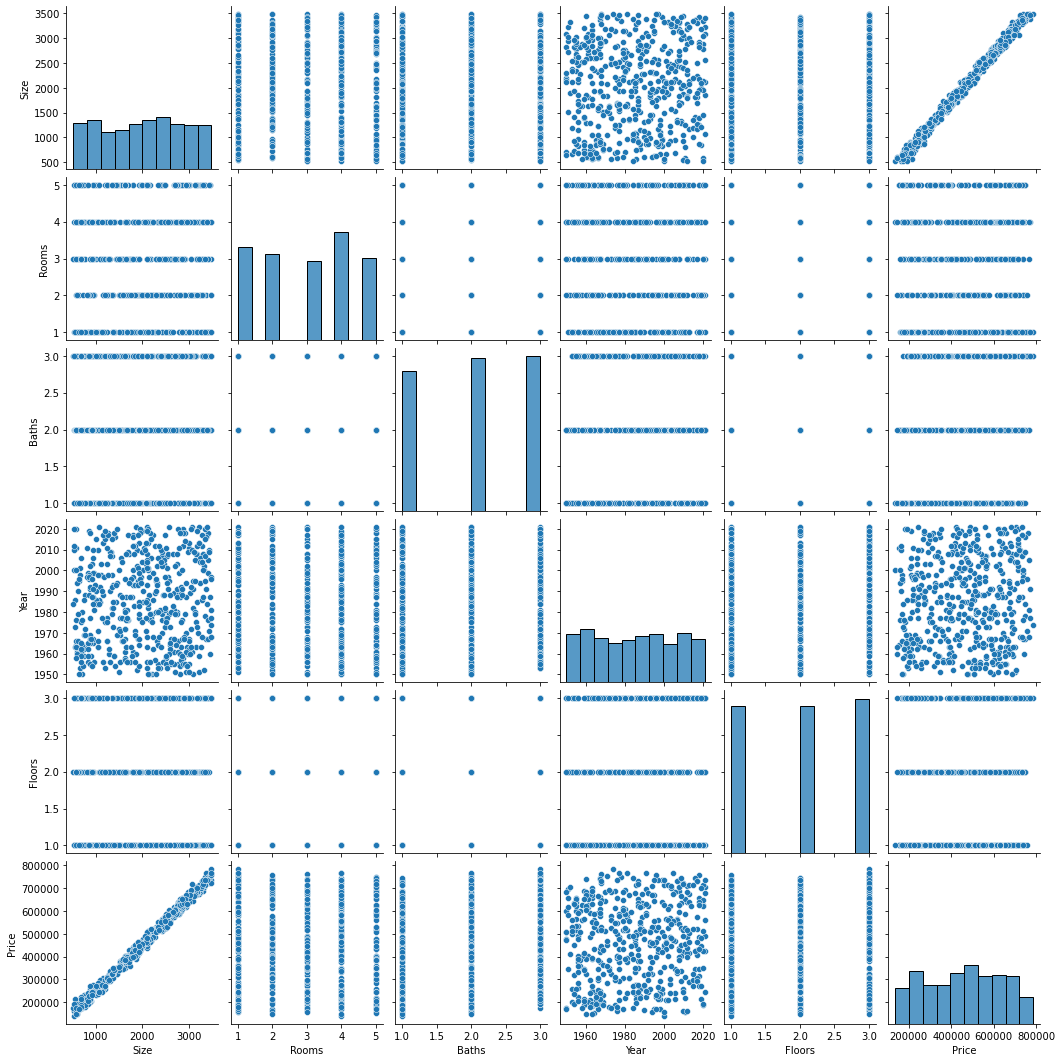

In [10]:
sns.pairplot(data=data);

# İstatistiksel Analiz

In [13]:
# bağımlı ve bağımsız değişkenleri oluşturalım.
X = data[['Size', 'Rooms', 'Baths', 'Year', 'Floors']]
y = data['Price']

In [15]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.597e+05
Date:                Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:29:05   Log-Likelihood:                         -5294.4
No. Observations:                 500   AIC:                                  1.060e+04
Df Residuals:                     495   BIC:                                  1.062e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Size         201.2093      0.499    403.253      0.000     200.229     202.190
Rooms       -517.0313    306.484     -1.687      0.092   -1119.201      85.139
Baths       1.599e+04    534.641     29.912      0.000    1.49e+04     1.7e+04
Year           5.6944      1.045      5.447      0.000       3.640       7.748
Floors      5263.6129    529.693      9.937      0.000    4222.889    6304.337
==============================================================================
Omnibus:                        2.246   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                2.072
Skew:                           0.103   Prob(JB):                        0.355
Kurtosis:                       3.239   Cond. No.                     3.71e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### R-kare değeri 1 çıktı. Bu, bağımsız değişkenlerin bağımlı değişkeni açıklama gücünün çok iyi olduğunu gösteriyor. p-value değerinin 0.05 'den küçük olmuş olması istatistiksel olarak anlamlı bir model oluşturabileceğimizi gösteriyor.

# Model Oluşturma ve Değerlendirme

In [16]:
# eğitim ve test setlerini ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# modelimizi oluşturalım ve eğitelim
model = LinearRegression().fit(X_train, y_train)

In [18]:
# tahmin
y_pred = model.predict(X_test)

In [21]:
# model değerlendirme
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-kare değeri: ', r2)
print('MSE Değeri: ', mse)

R-kare değeri:  0.997091912736477
MSE Değeri:  97652385.57625805


# Model tuning işlemi

In [38]:
# en iyi random_state değerini bulalım.

for element in range(0, 100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=element)
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    if r2 > 0.997091912736477:
        print(f'random_state={element} için R-kare değeri: ', r2)

random_state=3 için R-kare değeri:  0.9974203756066495
random_state=4 için R-kare değeri:  0.9972256963093539
random_state=9 için R-kare değeri:  0.9972043882764926
random_state=10 için R-kare değeri:  0.9974465484707363
random_state=12 için R-kare değeri:  0.9979700288648756
random_state=15 için R-kare değeri:  0.9975470276552879
random_state=20 için R-kare değeri:  0.9972436838832676
random_state=23 için R-kare değeri:  0.9971549012274303
random_state=27 için R-kare değeri:  0.9971698531308544
random_state=28 için R-kare değeri:  0.99716802450494
random_state=29 için R-kare değeri:  0.997329355505357
random_state=33 için R-kare değeri:  0.9977659450996743
random_state=35 için R-kare değeri:  0.9973690979109213
random_state=37 için R-kare değeri:  0.9976637795927901
random_state=38 için R-kare değeri:  0.997217212351733
random_state=41 için R-kare değeri:  0.9971410849873908
random_state=47 için R-kare değeri:  0.9975031591016814
random_state=48 için R-kare değeri:  0.9975284459355533

In [40]:
# en iyi hiperparametreleri bulma

params = {'fit_intercept':[True, False], 'copy_X':[True, False]}
grid = GridSearchCV(model, param_grid=params, cv=5)
grid.fit(X_train, y_train)
print('En iyi parametreler: ', grid.best_params_)

En iyi parametreler:  {'copy_X': True, 'fit_intercept': False}


In [41]:
model = LinearRegression(fit_intercept=False, copy_X=True).fit(X_train, y_train)

In [42]:
y_pred = model.predict(X_test)

In [43]:
r2 = r2_score(y_test, y_pred)
print('R-kare değeri: ', r2)

R-kare değeri:  0.9971855152646493


# Tahmin

In [44]:
data.head()

,Size,Rooms,Baths,Location,Year,Floors,Price
0,3183,5,2,A,2008,3,707105.607678
1,603,1,3,C,1961,2,196458.459536
2,2227,4,3,A,1999,2,508298.073802
3,1199,4,1,C,1953,2,256996.466357
4,2677,4,3,B,1961,2,616396.304566


In [52]:
size = int(input('Lütfen evinizin metrekaresini giriniz: '))
rooms = int(input('Lütfen evinizin oda sayısını giriniz: '))
baths = int(input('Lütfen evinizin banyo sayısını giriniz: '))
year = int(input('Lütfen evinizin yapılış yılını giriniz: '))
floors = int(input('Lütfen evinizin kat sayısını giriniz: '))

predict = np.array([[size, rooms, baths, year, floors]])
predict = model.predict(predict)
print('-------------------------------------------------------------------')
print('Evinizin tahmini değeri: ', int(predict), 'TL.')

Lütfen evinizin metrekaresini giriniz:  10000
Lütfen evinizin oda sayısını giriniz:  2
Lütfen evinizin banyo sayısını giriniz:  3
Lütfen evinizin yapılış yılını giriniz:  2012
Lütfen evinizin kat sayısını giriniz:  1


-------------------------------------------------------------------
Evinizin tahmini değeri:  2078462 TL.


C:\Users\murat\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
